We extract and prepare data from the [2019 cell reports data](https://www.cell.com/cell-reports/fulltext/S2211-1247(18)31982-X) for our 4D cell classification. The 2019 cell reports data has 28 WT-EMB embryos, for each cell, we can extract its trajectory, mother cell, daughter cells and division angles.

To do this, we can first get all unique cell names across 28 embryos, then:
1. Build [lineage graph](http://wormweb.org/celllineage#c=P4a&z=1) based on cell names: <br/>
   there are only 6 special naming cases in division: `{P0:[AB, P1], P1:[EMS, P2], P2:[C, P3], P3:[D, P4], P4:[Z3, Z2], EMS:[E, MS]}`; <br/>
   in all the other cases, daughter cells are named by appending `a/p, l/r, d/v` of their mother cell, where `a/p` are the majority divisions.   
2. Extract trajectory and division info based on cell names and lineage graph


# Build lineage graph

In [1]:
import numpy as np 
import pandas as pd 
import networkx as nx 
from matplotlib import pyplot as plt
from pathlib import Path
import tqdm
import time
import json
import pickle
from collections import deque

In [2]:
# Extract all cell names
tracking_folder = './Cell-lineage-and-position-WT-compressed_canonical_orientation/'
voxel_size_zyx = (1,0.22,0.22) # um, in ZYX order for anisotropic voxel
temporal_resolution = 1.25 # min per frame
# Build Atlas
atlas = {}
for embryo_index in range(1,29):
    embryo_name = f'WT-EMB{str(embryo_index).zfill(2)}'
    tracking_GT = pd.read_csv(f'{tracking_folder}/{embryo_name}.txt', delimiter='\t', index_col=[0])
    tracking_GT['Z'], tracking_GT['Y'], tracking_GT['X'] = tracking_GT['Z']*voxel_size_zyx[0], tracking_GT['Y']*voxel_size_zyx[1], tracking_GT['X']*voxel_size_zyx[2] 
    atlas[embryo_name] = tracking_GT

In [3]:
atlas.keys()

dict_keys(['WT-EMB01', 'WT-EMB02', 'WT-EMB03', 'WT-EMB04', 'WT-EMB05', 'WT-EMB06', 'WT-EMB07', 'WT-EMB08', 'WT-EMB09', 'WT-EMB10', 'WT-EMB11', 'WT-EMB12', 'WT-EMB13', 'WT-EMB14', 'WT-EMB15', 'WT-EMB16', 'WT-EMB17', 'WT-EMB18', 'WT-EMB19', 'WT-EMB20', 'WT-EMB21', 'WT-EMB22', 'WT-EMB23', 'WT-EMB24', 'WT-EMB25', 'WT-EMB26', 'WT-EMB27', 'WT-EMB28'])

In [4]:
# Extract all cells
all_cells = set()
for embryo in atlas:
    all_cells.update(atlas[embryo]['cell_name'])
print(len(all_cells))

781


In [5]:
'P0' in all_cells

True

In [6]:
'Z2' in all_cells, 'Z3' in all_cells

(True, True)

In [7]:
lineage_graph_dict_of_lists = {'P0':['AB', 'P1'], 'P1':['EMS', 'P2'], 'P2':['C', 'P3'], 'P3':['D', 'P4'], 'P4':['Z3', 'Z2'], 'EMS':['E', 'MS'], 'Z2':[], 'Z3':[]}
# we can use BFS to build the graph
frontiers = deque(['AB','C','D','E','MS'])
while frontiers:
    for i in range(len(frontiers)):
        node = frontiers.popleft()
        potential_daughter_cells = [f'{node}a',f'{node}p',f'{node}l',f'{node}r',f'{node}d',f'{node}v']
        daughter_nodes = [cell for cell in potential_daughter_cells if cell in all_cells]
        lineage_graph_dict_of_lists[node] = daughter_nodes 
        frontiers.extend(daughter_nodes)

In [8]:
lineage_graph_dict_of_lists

{'P0': ['AB', 'P1'],
 'P1': ['EMS', 'P2'],
 'P2': ['C', 'P3'],
 'P3': ['D', 'P4'],
 'P4': ['Z3', 'Z2'],
 'EMS': ['E', 'MS'],
 'Z2': [],
 'Z3': [],
 'AB': ['ABa', 'ABp'],
 'C': ['Ca', 'Cp'],
 'D': ['Da', 'Dp'],
 'E': ['Ea', 'Ep'],
 'MS': ['MSa', 'MSp'],
 'ABa': ['ABal', 'ABar'],
 'ABp': ['ABpl', 'ABpr'],
 'Ca': ['Caa', 'Cap'],
 'Cp': ['Cpa', 'Cpp'],
 'Da': ['Daa', 'Dap'],
 'Dp': ['Dpa', 'Dpp'],
 'Ea': ['Eal', 'Ear'],
 'Ep': ['Epl', 'Epr'],
 'MSa': ['MSaa', 'MSap'],
 'MSp': ['MSpa', 'MSpp'],
 'ABal': ['ABala', 'ABalp'],
 'ABar': ['ABara', 'ABarp'],
 'ABpl': ['ABpla', 'ABplp'],
 'ABpr': ['ABpra', 'ABprp'],
 'Caa': ['Caaa', 'Caap'],
 'Cap': ['Capa', 'Capp'],
 'Cpa': ['Cpaa', 'Cpap'],
 'Cpp': ['Cppa', 'Cppp'],
 'Daa': ['Daaa', 'Daap'],
 'Dap': ['Dapa', 'Dapp'],
 'Dpa': ['Dpaa', 'Dpap'],
 'Dpp': ['Dppa', 'Dppp'],
 'Eal': ['Eala', 'Ealp'],
 'Ear': ['Eara', 'Earp'],
 'Epl': ['Epla', 'Eplp'],
 'Epr': ['Epra', 'Eprp'],
 'MSaa': ['MSaaa', 'MSaap'],
 'MSap': ['MSapa', 'MSapp'],
 'MSpa': ['MSpaa', 

In [9]:
import json
with open( './lineage_tree.json', 'w') as f:
   json.dump(lineage_graph_dict_of_lists, f)

In [10]:
len(lineage_graph_dict_of_lists) == len(all_cells)

True

In [11]:
np.unique([len(lineage_graph_dict_of_lists[node]) for node in lineage_graph_dict_of_lists])

array([0, 2])

In [12]:
len([node for node in lineage_graph_dict_of_lists if len(lineage_graph_dict_of_lists[node])==0]), [node for node in lineage_graph_dict_of_lists if len(lineage_graph_dict_of_lists[node])==0]

(391,
 ['Z2',
  'Z3',
  'Daaa',
  'Daap',
  'Dpaa',
  'Dpap',
  'Caapa',
  'Dapaa',
  'Dapap',
  'Dappa',
  'Dappp',
  'Dppaa',
  'Dppap',
  'Dpppa',
  'Dpppp',
  'Ealaa',
  'Ealap',
  'Ealpa',
  'Ealpp',
  'Earaa',
  'Earap',
  'Earpa',
  'Earpp',
  'Eplaa',
  'Eplap',
  'Eplpa',
  'Eplpp',
  'Epraa',
  'Eprap',
  'Eprpa',
  'Eprpp',
  'Caaaaa',
  'Caaaap',
  'Caaapa',
  'Caaapp',
  'Caappd',
  'Caappv',
  'Capaaa',
  'Capaap',
  'Capapa',
  'Capapp',
  'Cappaa',
  'Cappap',
  'Capppa',
  'Capppp',
  'Cpaaaa',
  'Cpaaap',
  'Cpaapa',
  'Cpaapp',
  'Cpapaa',
  'Cpapap',
  'Cpappd',
  'Cpappv',
  'Cppaaa',
  'Cppaap',
  'Cppapa',
  'Cppapp',
  'Cpppaa',
  'Cpppap',
  'Cppppa',
  'Cppppp',
  'MSaappa',
  'MSpaapp',
  'MSpappa',
  'MSaaaaaa',
  'MSaaaapa',
  'MSaaaapp',
  'MSaaapaa',
  'MSaaapap',
  'MSaaappa',
  'MSaaappp',
  'MSaapaaa',
  'MSaapaap',
  'MSaapapa',
  'MSaapapp',
  'MSaapppa',
  'MSaapppp',
  'MSapaaaa',
  'MSapaaap',
  'MSapaapa',
  'MSapaapp',
  'MSapapaa',
  'MSapapap'

In [13]:
[node for node in lineage_graph_dict_of_lists if node.startswith('Da')]

['Da',
 'Daa',
 'Dap',
 'Daaa',
 'Daap',
 'Dapa',
 'Dapp',
 'Dapaa',
 'Dapap',
 'Dappa',
 'Dappp']

In [14]:
lineage_graph = nx.from_dict_of_lists(lineage_graph_dict_of_lists, create_using=nx.DiGraph)

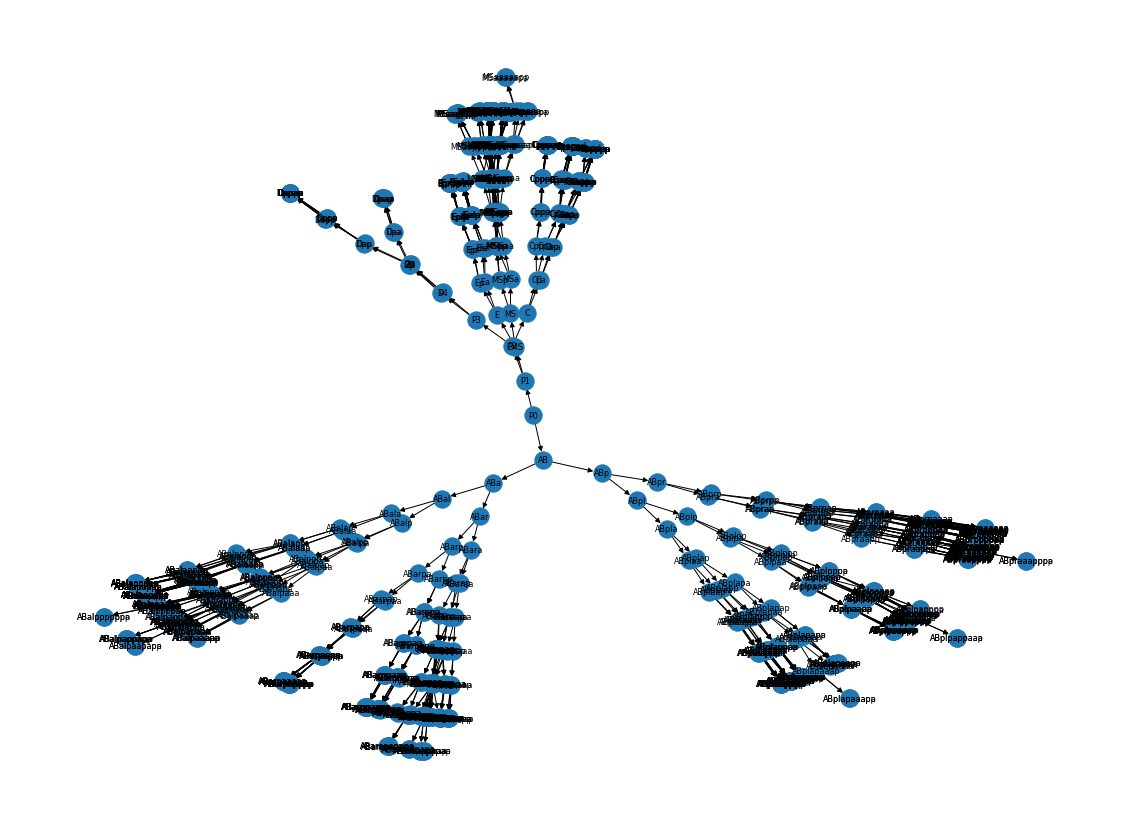

In [15]:
# Visualize the trie
fig, ax = plt.subplots(figsize = (20,15))
nx.draw(lineage_graph, pos=nx.kamada_kawai_layout(lineage_graph), with_labels=True, ax=ax, font_size=8)

We can see we successfully build the lineage graph.

# Extract trajectory